# Springboard - Data Science Career Track

# Capstone Project I: Kiva.org loan delays

### Goal of the project:
    
**Understand what may cause a higher delay between:**

-  the "posted time" (the time at which the loan is posted on Kiva by the field agent)
-  the "funded time" (the time at which the loan posted to Kiva gets 100% funded by lenders)
- the "disbursed time" (the time at which the loan is disbursed by the field agent to the borrower)

#### **The journey of a Kiva loan**

- A borrower applies for a loan.
- The loan goes through the underwriting and approval process
- If it is approved, the loan disbursal period starts
    - The loan is posted to Kiva for lenders to support
    - Fundraising period
    - Fundraising complete (or not)
- Borrower repays the loan
- Lenders use repayments to fund new loans, donate or withdraw the money.

Partner loans are administered by Kiva’s Field Partners and are available to borrowers in more than 80 countries. Direct loans are made using the digital payment system and don’t involve a Field Partner.

**Note**: *Disbursal* refers to when the borrower can access the money, but the timing of it can vary:    
  - For most Field Partner loans, the money is *pre-disbursed* (when partners give the funds out before the loan is posted), so the borrower can access the funds right away. 
  - For direct loans, the money is disbursed only after the loan has been fully crowdfunded on the Kiva website.

### Libraries

In [1]:
# First, import the relevant modules
%matplotlib inline
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import zscore
from collections import Counter
# import re

In [2]:
cd C:\Users\Admin\Desktop\Capstone Project 1 - all ideas\Kiva\Additional resources for Kiva Crowdfunding - Region inclusion for Kiva locations with poverty decomposition

C:\Users\Admin\Desktop\Capstone Project 1 - all ideas\Kiva\Additional resources for Kiva Crowdfunding - Region inclusion for Kiva locations with poverty decomposition


## 1) Data inspection and Cleaning

In [3]:
# filename
kiva_data = pd.read_csv("all_kiva_loans_copy.csv")

### Overview and cleaning

In [4]:
kiva_data.head(3)

,loan_id,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,...,currency,partner_id,posted_time,planned_expiration_time,disburse_time,raised_time,lender_term,num_lenders_total,borrower_genders,repayment_interval
0,657307,125.0,125.0,funded,General Store,Retail,to buy additional inventories for her sari-sa...,PH,Philippines,Ozamiz - Ozamiz City,...,PHP,126.0,2014-01-15 02:23:45.000 +0000,2014-02-14 03:30:06.000 +0000,2013-12-22 08:00:00.000 +0000,2014-01-15 04:48:22.000 +0000,7.0,3,female,irregular
1,657259,400.0,400.0,funded,Used Clothing,Clothing,"To buy American clothing such as blouses, shir...",HN,Honduras,"La Lopez, Choloma",...,HNL,201.0,2014-01-14 20:23:20.000 +0000,2014-03-26 22:25:07.000 +0000,2013-12-20 08:00:00.000 +0000,2014-02-25 06:42:06.000 +0000,8.0,11,female,monthly
2,658010,400.0,400.0,funded,General Store,Retail,"to buy stock of rice, sugar and flour",PK,Pakistan,Lala Musa,...,PKR,245.0,2014-01-16 11:32:58.000 +0000,2014-02-15 21:10:05.000 +0000,2014-01-09 08:00:00.000 +0000,2014-01-24 23:06:18.000 +0000,14.0,16,female,monthly


In [5]:
kiva_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1419607 entries, 0 to 1419606
Data columns (total 21 columns):
loan_id                    1419607 non-null int64
funded_amount              1419607 non-null float64
loan_amount                1419607 non-null float64
status                     1419607 non-null object
activity_name              1419607 non-null object
sector_name                1419607 non-null object
loan_use                   1376334 non-null object
country_code               1419598 non-null object
country_name               1419607 non-null object
town_name                  1257849 non-null object
currency_policy            1419607 non-null object
currency                   1419607 non-null object
partner_id                 1402817 non-null float64
posted_time                1419607 non-null object
planned_expiration_time    1047773 non-null object
disburse_time              1416794 non-null object
raised_time                1355325 non-null object
lender_term       

In [6]:
# describe dataframe numericals
kiva_data.describe()

,loan_id,funded_amount,loan_amount,partner_id,lender_term,num_lenders_total
count,1.419607e+06,1.419607e+06,1.419607e+06,1.402817e+06,1.419583e+06,1.419607e+06
mean,7.233713e+05,7.961254e+02,8.322284e+02,1.496207e+02,1.305139e+01,2.225389e+01
std,4.156766e+05,1.034257e+03,1.080551e+03,8.769345e+01,7.566660e+00,2.777410e+01
min,8.400000e+01,0.000000e+00,2.500000e+01,1.000000e+00,1.000000e+00,0.000000e+00
25%,3.642165e+05,2.750000e+02,3.000000e+02,9.800000e+01,8.000000e+00,8.000000e+00
50%,7.240350e+05,5.000000e+02,5.000000e+02,1.390000e+02,1.200000e+01,1.500000e+01
75%,1.082972e+06,9.500000e+02,1.000000e+03,1.740000e+02,1.400000e+01,2.700000e+01
max,1.444085e+06,1.000000e+05,1.000000e+05,5.570000e+02,1.950000e+02,3.045000e+03


#### Changing dtpes and labels

In [7]:
# Changing some column names, for clarity
kiva_data.rename(columns={'disburse_time':'disbursed_time', 'raised_time':'funded_time'}, inplace=True)

In [8]:
# change the dtype of the main variables of study to datetime64[ns]
kiva_data['posted_time'] = pd.to_datetime(kiva_data['posted_time'], errors='coerce')
kiva_data['planned_expiration_time'] = pd.to_datetime(kiva_data['planned_expiration_time'], errors='coerce')
kiva_data['disbursed_time'] = pd.to_datetime(kiva_data['disbursed_time'], errors='coerce')
kiva_data['funded_time'] = pd.to_datetime(kiva_data['funded_time'], errors='coerce')

### Main variables inspection and cleaning

#### 1) 'posted_time'

In [9]:
# As seen above, there are no missing values and the filled ones seem to be ok
kiva_data[['posted_time', 'disbursed_time', 'funded_time']].describe()

,posted_time,disbursed_time,funded_time
count,1419607,1416794,1355325
unique,1415162,75668,1137793
top,2006-04-16 07:10:50,2017-02-01 08:00:00,2005-03-31 06:27:55
freq,207,2800,203
first,2006-04-16 07:10:50,2005-04-14 05:27:55,2005-03-31 06:27:55
last,2018-01-11 07:11:23,2018-03-19 07:00:00,2018-01-11 03:11:44


In [10]:
# checking frequency
kiva_data['posted_time'].value_counts().head()

2006-04-16 07:10:50    207
2015-05-27 08:05:17      3
2008-02-12 22:15:45      3
2015-03-12 08:01:30      3
2016-04-26 08:08:20      3
Name: posted_time, dtype: int64

Apparently the 'posted_time' column is clean

#### 2) 'funded_time'

In [11]:
# filled and missing values
kiva_data['funded_time'].isna().value_counts()

False    1355325
True       64282
Name: funded_time, dtype: int64

- Regarding the **missing values**, even though some null-values might correspond to loans which were indeed funded (as seen in the example below), there is not a way to know how to fill those values, and I will not consider the following ones for analysis, so that there is no ambiguity. 

In [12]:
# rows where there is a missing value in 'funded_time' but 'loan_amount' - 'funded_amount' <= 0

missing_ft = kiva_data[kiva_data['funded_time'].isna()] 
missing_ft[(missing_ft['loan_amount'] - missing_ft['funded_amount']) <= 0]

,loan_id,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,...,currency,partner_id,posted_time,planned_expiration_time,disbursed_time,funded_time,lender_term,num_lenders_total,borrower_genders,repayment_interval
142677,849172,700.0,700.0,expired,Cereals,Food,to buy maize to sell.,UG,Uganda,Hoima,...,UGX,163.0,2015-03-02 13:07:56,2015-04-06 12:20:02,2015-02-18 08:00:00,NaT,12.0,25,male,monthly
508508,985199,3400.0,3000.0,expired,Farm Supplies,Agriculture,"to pay for wires for the grape orchard, cover ...",AM,Armenia,"Hoktember village, Armavir region",...,USD,169.0,2015-11-25 10:53:00,2015-12-28 19:20:08,2015-10-29 07:00:00,NaT,38.0,84,male,monthly
628009,114629,125.0,125.0,refunded,Retail,Retail,NaN,PH,Philippines,NaN,...,PHP,128.0,2009-06-11 01:27:29,NaT,2009-05-29 07:00:00,NaT,12.0,5,NaN,irregular
657411,38915,1475.0,1475.0,expired,Food Market,Food,To expand fresh food business,UG,Uganda,Nansana,...,UGX,65.0,2008-02-28 07:10:56,NaT,2008-07-22 07:00:00,NaT,NaN,24,"female, female, female, female, female",irregular
809473,924149,425.0,400.0,expired,General Store,Retail,"to buy beverages, rice, laundry detergent, sug...",MZ,Mozambique,"Boane, Maputo",...,MZN,23.0,2015-07-28 07:14:04,2015-09-09 18:30:02,2015-07-22 07:00:00,NaT,17.0,11,male,monthly
861839,147,1000.0,1000.0,refunded,Farming,Agriculture,NaN,BG,Bulgaria,NaN,...,USD,3.0,2006-04-16 07:10:50,NaT,2006-03-15 05:00:00,NaT,6.0,16,NaN,bullet
1368801,408534,1275.0,1275.0,expired,Agriculture,Agriculture,To buy the inventory for his fruit and vegetab...,AZ,Azerbaijan,NaN,...,AZN,207.0,2012-03-24 13:05:34,2012-05-02 15:00:03,2012-03-07 08:00:00,NaT,20.0,44,female,monthly


In [13]:
# checking if there are nulls
kiva_data[kiva_data['funded_time'] == 0]

,loan_id,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,...,currency,partner_id,posted_time,planned_expiration_time,disbursed_time,funded_time,lender_term,num_lenders_total,borrower_genders,repayment_interval


The remaining missing values will be kept due to several reasons. Not every loan is funded, or when there is a filled value in 'funded_amount', because the loan may not be completely funded yet, that is, the 'funded_amount' is smaller than the 'loan_amount' (although it implies disbursal).

- Regarding the **filled values**, there are 2 columns with which we can compare to check if there are discrepancies:

    - 'funded_amount' and 'status'

*'funded_time' vs 'funded_amount'*

In [14]:
# Comparing with the 'funded_amount' column, there are no discrepancies
kiva_data[(kiva_data['funded_time'].notnull()) & (kiva_data['funded_amount'] > 0)].count()[['funded_time', 'funded_amount']]

funded_time      1355325
funded_amount    1355325
dtype: int64

In [15]:
# However, when looking at the difference between 'loan_amount' and 'funded_amount', we notice inconsistency in the data
ft_notnull = kiva_data[kiva_data['funded_time'].notnull()] 
ft_notnull[(ft_notnull['loan_amount'] - ft_notnull['funded_amount']) > 0]  

,loan_id,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,...,currency,partner_id,posted_time,planned_expiration_time,disbursed_time,funded_time,lender_term,num_lenders_total,borrower_genders,repayment_interval
60715,57210,925.0,950.0,funded,Clothing,Clothing,Increase business capital,RW,Rwanda,Gasabo/Buliza/Rwanda,...,RWF,117.0,2008-07-17 15:59:58,NaT,2008-08-05 07:00:00,2008-07-22 18:26:42,14.0,35,female,monthly
233811,44276,475.0,500.0,funded,Food Production/Sales,Food,NaN,KE,Kenya,NaN,...,KES,36.0,2008-04-08 13:26:42,NaT,2008-05-03 05:39:35,2008-04-19 05:39:35,14.0,14,NaN,monthly
518536,48958,25.0,950.0,refunded,Food Production/Sales,Food,NaN,SN,Senegal,NaN,...,XOF,105.0,2008-05-15 16:09:47,NaT,2008-05-31 07:00:00,2008-05-17 22:33:56,8.0,1,NaN,monthly
577064,745,125.0,1000.0,refunded,Sewing,Services,NaN,KH,Cambodia,NaN,...,USD,9.0,2006-08-18 09:12:23,NaT,2006-09-11 02:34:47,2006-08-28 02:34:47,21.0,4,NaN,monthly


Hence, I will not consider these rows too, so that the data is clear.

*'funded_time' vs 'status'*

In [16]:
# Comparing with the 'status' column:

# datetime and status columns described
kiva_data[['posted_time', 'funded_time', 'status']].describe()

,posted_time,funded_time,status
count,1419607,1355325,1419607
unique,1415162,1137793,4
top,2006-04-16 07:10:50,2005-03-31 06:27:55,funded
freq,207,203,1350340
first,2006-04-16 07:10:50,2005-03-31 06:27:55,NaN
last,2018-01-11 07:11:23,2018-01-11 03:11:44,NaN


In [17]:
# status column variables
kiva_data['status'].value_counts()

funded         1350340
expired          59081
refunded          6578
fundRaising       3608
Name: status, dtype: int64

In [18]:
# comparing 'funded_time' non nulls with 'status':funded

kiva_data[(kiva_data['status'] == 'funded') & (kiva_data['funded_time'].notnull())].count()[['funded_time', 'status']]

funded_time    1350340
status         1350340
dtype: int64

Whenever the loan is described as 'funded', a corresponding value appears in the 'funded_time' column.

In [19]:
# comparing 'funded_time' non nulls with 'status' = refunded

kiva_data[(kiva_data['status'] == 'refunded') & (kiva_data['funded_time'].notnull())].count()[['funded_time', 'status']]

funded_time    4983
status         4983
dtype: int64

Whenever the loan is described as 'refunded', a corresponding value appears in the 'funded_time' column.

We can see that the sum of the rows where the status is indicated as 'funded' with the ones where it is indicated as 'refunded' has less 2 values than the total number of 'funded_time' values

In [20]:
# 'funded_time' non nulls with 'status':funded
ft_f = kiva_data[(kiva_data['status'] == 'funded') & (kiva_data['funded_time'].notnull())].count().status 

# 'funded_time' non nulls with 'status' = refunded
ft_ref = kiva_data[(kiva_data['status'] == 'refunded') & (kiva_data['funded_time'].notnull())].count().status

# 'funded_time' total non nulls
ft_tot = kiva_data['funded_time'].count()


ft_tot - (ft_f + ft_ref)

2

In [21]:
# comparing 'funded_time' non nulls with 'status' = expired

kiva_data[(kiva_data['status'] == 'expired') & (kiva_data['funded_time'].notnull())]

,loan_id,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,...,currency,partner_id,posted_time,planned_expiration_time,disbursed_time,funded_time,lender_term,num_lenders_total,borrower_genders,repayment_interval
926652,601656,925.0,925.0,expired,Home Products Sales,Retail,to purchase clothing and household items for r...,GE,Georgia,Vani,...,GEL,181.0,2013-08-29 13:43:33,2013-10-03 15:10:02,2013-07-31 07:00:00,2013-10-03 15:16:01,15.0,29,female,monthly
1144537,149173,4600.0,4600.0,expired,Retail,Retail,Increase working capital,BO,Bolivia,NaN,...,BOB,73.0,2009-10-30 20:19:53,NaT,2009-10-29 07:00:00,2009-12-01 07:12:13,8.0,125,"female, female, female, female, female, female...",monthly


We have two loans requests which supposedly expired but, at the same time, two values for the 'funded_time' column are filled.

In this case, however, every other variable seem to indicate that the loan was indeed funded, so I will consider them for analysis. 
For example, in the first case, what probably classified the status as expired was the fact that the funded_time was slightly after (6 minutes) the planned_expiration_time.

These two values are the ones which were missing from the previous analysis.

I will change the status in these two cases to 'funded'.

In [22]:
to_replace = (kiva_data['status'] == 'expired') & (kiva_data['funded_time'].notnull())

kiva_data.loc[to_replace, 'status'] = 'funded'

In [23]:
# comparing 'funded_time' non nulls with 'status' = fundRaising

kiva_data[(kiva_data['status'] == 'fundRaising') & (kiva_data['funded_time'].notnull())].count()[['funded_time', 'status']]

funded_time    0
status         0
dtype: int64

Hence, I will consider all values in the 'funded_time' series, null and non-null, with the exception of the following cases:

In [24]:
# rows where there is a missing value in 'funded_time' but 'loan_amount' - 'funded_amount' <= 0
missing_ft = kiva_data[kiva_data['funded_time'].isna()] 
not_rows = missing_ft[(missing_ft['loan_amount'] - missing_ft['funded_amount']) <= 0]

# and

# rows where 'funded_time' is not null but 'loan_amoun' - 'funded_amount' > 0
ft_notnull = kiva_data[kiva_data['funded_time'].notnull()] 
not_rows_2 = ft_notnull[(ft_notnull['loan_amount'] - ft_notnull['funded_amount']) > 0]

I will use a new dataframe named data

In [25]:
# removing the rows
data = kiva_data.drop(not_rows.index)
data = data.drop(not_rows_2.index)

In [26]:
# new shape
data.shape

(1419596, 21)

#### 3) 'disbursed_time'

In [27]:
# filled and missing values
data['disbursed_time'].isna().value_counts()

False    1416783
True        2813
Name: disbursed_time, dtype: int64

- Regarding the **missing values**:

As said in the introduction, the "disbursed time" is the time at which the loan is disbursed by the field agent or group of lenders to the borrower. We can compare them to other variables to see if the data is coherent. 

It would not be as such if there was a missing 'disbursed_time' value and the variables 'funded_amount', 'funded_time', status = funded or status = refunded were filled. 

In [28]:
# Cases where:

# - The 'funded_amount' is greater than 0, or
# - The 'status' is classified as funded or refunded, or
# - The 'funded_time' is filled

data[(data['disbursed_time'].isnull()) & ((data['funded_amount'] > 0) | (data['status'] == 'funded') | (data['status'] == 'refunded') | (data['funded_time'].notnull()))].count()[['funded_amount', 'status', 'funded_time']]

funded_amount    1823
status           1823
funded_time       271
dtype: int64

I will remove these rows for our analysis, so that there is no ambiguity.

In [29]:
missing_disbursed = data[(data['disbursed_time'].isnull()) & ((data['funded_amount'] > 0) | (data['status'] == 'funded') | (data['status'] == 'refunded') | (data['funded_time'].notnull()))]

# removing the rows
data = data.drop(missing_disbursed.index)

# new shape
data.shape

(1417773, 21)

In [30]:
# new number of missing values
data['disbursed_time'].isna().value_counts()

False    1416783
True         990
Name: disbursed_time, dtype: int64

Those missing values will remain for our analysis

- Regarding the **filled values**

As said in the introduction, the timing of the disbursal can vary. For most Field Partner loans, the money is pre-disbursed, so the borrower can access the funds right away. Hence, it is not strange if the 'disbursed_time' is made even before the 'posted_time', either filled or not. For direct loans, the money is disbursed only after the loan has been fully crowdfunded on the Kiva website.

In [31]:
# cases where disbursed_time is after the funded_time
data[data['disbursed_time'] > data['funded_time']].count()[['funded_time', 'disbursed_time']]

funded_time       117823
disbursed_time    117823
dtype: int64

There are cases where the disbursed_time of the loan is after the funded_time, but we will keep these values since the Field Partner or Kiva (in the case of a direct loan) may try to reschedule repayments on the delinquent loan in order to make it possible for the borrower to eventually repay and assume the risk in some cases. 

Regarding the filled values, there are not more comparisons we can make to see if the data is coherent or not.

#### 4) 'posted_time' vs 'funded_time'

As we have seen, the chronological order between the 'posted_time' and the 'disbursal_time' does not matter, as well as between the 'disbursal_time' and the 'funded_time'.

What could biase the data is when the 'funded_time' appears before the 'posted_time'.

In [32]:
# cases
pt_ft_cases = data[data['funded_time'] < data['posted_time']]

# brief look
pt_ft_cases[['funded_time', 'posted_time']].head()

,funded_time,posted_time
85222,2005-03-31 06:27:55,2006-04-16 07:10:50
85369,2005-03-31 06:27:55,2006-04-16 07:10:50
89113,2005-03-31 06:27:55,2006-04-16 07:10:50
99222,2005-03-31 06:27:55,2006-04-16 07:10:50
106582,2005-03-31 06:27:55,2006-04-16 07:10:50


In [33]:
# number of cases where 'funded_time' is made before the 'posted_time' 
pt_ft_cases.count()[['funded_time', 'posted_time']]

funded_time    203
posted_time    203
dtype: int64

In [34]:
# unique dates where 'funded_time' is made before the 'posted_time'
set(pt_ft_cases.posted_time)

{Timestamp('2006-04-16 07:10:50')}

In [35]:
# unique time differences
set(pt_ft_cases['posted_time'] - pt_ft_cases['funded_time'])

{Timedelta('381 days 00:42:55')}

In [36]:
# first posted_time date
min(data['posted_time'])

Timestamp('2006-04-16 07:10:50')

As we can see, these cases correspond to the loans which were first posted by Kiva. As the difference in these cases is considerable, I will not consider them for analysis.

In [37]:
# removing the rows
data = data.drop(pt_ft_cases.index)

# new shape
data.shape

(1417570, 21)

#### Other variables

The 'funded_amount' column appears to be compatible with the 'num_lenders_total' column. 

In [38]:
# funded_amount  
print("There are", data['funded_amount'][data['funded_amount'] == 0].count(), "zeros in the column 'funded_amount'")

# num_lenders_total
print("There are", data['num_lenders_total'][data['num_lenders_total'] == 0].count(), "zeros in the column 'num_lenders_total'")

There are 2516 zeros in the column 'funded_amount'
There are 2516 zeros in the column 'num_lenders_total'


#### Checking for misspellings

*'activity_name'*

In [39]:
# Create the series of activities
activities = data['activity_name']

# drop duplicates
activities = activities.drop_duplicates()

# creating the pattern to look for
pattern = '^[A-Za-z\.\s]*$'

# mask
mask = activities.str.contains(pattern)

# Inverting the mask: mask_inverse
mask_inverse = ~mask

#Subset activities using mask_inverse: invalid_activities
invalid_activities = activities.loc[mask_inverse]

# printing
invalid_activities 

# Conclusion: everything normal

24                  Fruits & Vegetables
26                Food Production/Sales
83         Cloth & Dressmaking Supplies
144      Primary/secondary school costs
175          Liquor Store / Off-License
553                       Fuel/Firewood
1591                Music Discs & Tapes
3155                 Movie Tapes & DVDs
15965                      Balut-Making
33786           Landscaping / Gardening
Name: activity_name, dtype: object

*'country_name'*

In [40]:
# Create the series of countries
countries = data['country_name']

# drop duplicates
countries = countries.drop_duplicates()

# creating the pattern to look for
pattern = '^[A-Za-z\.\s]*$'

# mask
mask = countries.str.contains(pattern)

# Inverting the mask: mask_inverse
mask_inverse = ~mask

#Subset activities using mask_inverse: invalid_activities
invalid_countries = countries.loc[mask_inverse]

# printing
invalid_countries 

# Conclusion: everything normal

269      Lao People's Democratic Republic
298                       Myanmar (Burma)
491                           Timor-Leste
23390                       Cote D'Ivoire
Name: country_name, dtype: object

### Searching for outliers

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1417570 entries, 0 to 1419606
Data columns (total 21 columns):
loan_id                    1417570 non-null int64
funded_amount              1417570 non-null float64
loan_amount                1417570 non-null float64
status                     1417570 non-null object
activity_name              1417570 non-null object
sector_name                1417570 non-null object
loan_use                   1374772 non-null object
country_code               1417561 non-null object
country_name               1417570 non-null object
town_name                  1257657 non-null object
currency_policy            1417570 non-null object
currency                   1417570 non-null object
partner_id                 1402601 non-null float64
posted_time                1417570 non-null datetime64[ns]
planned_expiration_time    1045948 non-null datetime64[ns]
disbursed_time             1416580 non-null datetime64[ns]
funded_time                1354847 non-null d

*1) 'loan_amount' and 'funded_amount'*

In [42]:
data[['funded_amount', 'loan_amount']].describe()

,funded_amount,loan_amount
count,1.417570e+06,1.417570e+06
mean,7.957836e+02,8.280732e+02
std,1.032980e+03,1.067993e+03
min,0.000000e+00,2.500000e+01
25%,2.750000e+02,3.000000e+02
50%,5.000000e+02,5.000000e+02
75%,9.500000e+02,1.000000e+03
max,1.000000e+05,1.000000e+05


In the previous analysis, when looking at the filled values in the 'funded_time' column, I did not include the cases where the funded_amount was greater than the loan_amount because it is acceptable. It is necessary, however, to check for outliers.

In [43]:
funded_amount_big = data[data['loan_amount'] < data['funded_amount']].funded_amount
loan_amount_small = data[data['loan_amount'] < data['funded_amount']].loan_amount

# general statistics of the difference:  
(funded_amount_big - loan_amount_small).describe()

count    10.000000
mean     27.500000
std       7.905694
min      25.000000
25%      25.000000
50%      25.000000
75%      25.000000
max      50.000000
dtype: float64

The differences are not significant.

Everything appears to be ok with the 'loan_amount' and 'funded_amount' values

*2) Main variables*

In [44]:
data[['posted_time', 'disbursed_time', 'funded_time']].describe()

,posted_time,disbursed_time,funded_time
count,1417570,1416580,1354847
unique,1413335,75663,1137608
top,2016-05-17 09:52:10,2017-02-01 08:00:00,2016-09-21 13:03:24
freq,3,2800,33
first,2006-04-16 07:10:50,2006-05-03 00:11:57,2006-04-19 00:11:57
last,2018-01-11 07:11:23,2018-03-19 07:00:00,2018-01-11 03:11:44


As the main variables fit approximately inside the same dates, there are no outliers regarding each one.

Looking at the differences between them:

*2.1) 'posted_time' and 'funded_time'*

It is not necessary to look for outliers here since we have already excluded the cases where the 'funded_time' was made before the 'posted_time' for analysis. The rest of the values we accept them at face value since they are between an acceptable range.

In [45]:
(data['funded_time'] - data['posted_time']).describe()

count                    1354847
mean     12 days 14:55:24.936868
std      13 days 11:14:07.002439
min              0 days 00:02:00
25%       3 days 13:14:12.500000
50%              7 days 18:27:30
75%      18 days 11:31:19.500000
max            533 days 17:22:00
dtype: object

*2.2) 'posted_time' and 'disbursed_time'*

In [46]:
(data['posted_time'] - data['disbursed_time']).describe()

count                    1416580
mean     12 days 04:36:06.951143
std      18 days 04:48:11.167029
min          -540 days +02:23:26
25%       5 days 19:58:28.750000
50%             14 days 02:57:52
75%      25 days 02:15:43.500000
max            118 days 16:28:59
dtype: object

As we have seen, the chronological order of these two dates does not matter, because the disbursal can be made before the posted time for most of the entities (Field partners). It is necessary to check for outliers, though.

Here I will focus only on the positive differences between posted_time and disbursed_time.

In [47]:
# defining outliers function based on zscore
def outliers_zscore(diff, threshold):
    zscore_diff = (diff - diff.mean())/diff.std()
    return zscore_diff[(zscore_diff > threshold) | (zscore_diff < -threshold)]

In [48]:
# cases where the disbursal is made before the posted_time
pt_dt_pos = data[data['posted_time'] > data['disbursed_time']]

# time difference between the two
pt_dt_pos_diff = pt_dt_pos['posted_time'] - pt_dt_pos['disbursed_time']

# describe
pt_dt_pos_diff.describe()

count                    1273566
mean     16 days 14:42:00.922162
std       9 days 15:11:11.397535
min              0 days 00:00:03
25%       7 days 20:42:53.250000
50%      16 days 02:17:43.500000
75%             26 days 03:07:27
max            118 days 16:28:59
dtype: object

In [49]:
# outliers for the difference between 'posted_time' and 'disbursed_time' (when positive) with a threshold = 3
outliers_pt_dt = outliers_zscore(pt_dt_pos_diff, 3)

# describe
outliers_pt_dt.describe()

count    135.000000
mean       4.380002
std        1.411533
min        3.023692
25%        3.323745
50%        4.049502
75%        4.600418
max       10.596565
dtype: float64

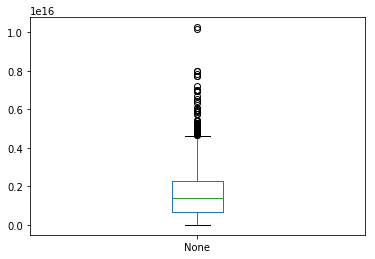

In [50]:
# boxplot
pt_dt_pos_diff.plot(kind='box')

plt.show()

In [51]:
data.ix[outliers_pt_dt.index]

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


,loan_id,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,...,currency,partner_id,posted_time,planned_expiration_time,disbursed_time,funded_time,lender_term,num_lenders_total,borrower_genders,repayment_interval
17072,114567,7450.0,7450.0,funded,Computers,Services,Training and certification for his computer an...,US,United States,"Atlanta, Georgia",...,USD,131.0,2009-06-10 20:14:22,NaT,2009-03-22 07:00:00,2009-06-21 02:37:18,26.0,236,male,monthly
17358,117254,175.0,175.0,funded,Pigs,Agriculture,To buy pig feed,PH,Philippines,"Surallah, South Cotabato",...,PHP,125.0,2009-06-22 00:58:11,NaT,2009-05-06 07:00:00,2009-06-22 02:05:24,6.0,6,female,bullet
17418,114264,5750.0,5750.0,funded,Services,Services,To buy a car for transporting packages,US,United States,"Queens, New York",...,USD,131.0,2009-06-09 16:55:37,NaT,2009-03-31 07:00:00,2009-06-20 20:18:43,27.0,171,male,monthly
36690,246230,1500.0,1500.0,funded,Butcher Shop,Food,To purchase meat for resale,KG,Kyrgyzstan,Tokmak,...,KGS,135.0,2010-11-09 05:39:58,NaT,2010-09-14 07:00:00,2010-11-15 18:34:32,7.0,46,"female, female, female, female",monthly
37027,245762,700.0,700.0,funded,Restaurant,Food,Purchase of ingredients,PH,Philippines,"Puerto Princesa, Palawan",...,PHP,145.0,2010-11-06 11:49:45,NaT,2010-09-20 07:00:00,2010-11-06 23:45:16,8.0,26,female,irregular
56748,114235,6000.0,6000.0,funded,Beauty Salon,Services,"Hair dryers, chairs and beauty products",US,United States,"Queens, New York",...,USD,131.0,2009-06-09 14:40:59,NaT,2009-03-27 07:00:00,2009-06-12 03:16:45,27.0,171,female,monthly
56822,117694,325.0,325.0,funded,Cereals,Food,"Buy corn, bags, and wood",NI,Nicaragua,Leon,...,NIO,74.0,2009-06-22 23:11:02,NaT,2009-04-17 07:00:00,2009-06-25 16:40:19,7.0,12,female,monthly
59475,113795,5000.0,5000.0,funded,Services,Services,Advertising and hiring new employee,US,United States,"San Francisco Bay Area, CA",...,USD,132.0,2009-06-08 03:25:20,NaT,2009-04-08 07:00:00,2009-06-18 01:47:13,38.0,161,male,monthly
99143,241774,500.0,500.0,funded,Vehicle,Personal Use,To purchase a motorbike,KH,Cambodia,Takeo Province,...,USD,9.0,2010-10-22 06:56:11,NaT,2010-08-26 07:00:00,2010-10-25 18:21:24,20.0,18,female,monthly
104692,238492,800.0,800.0,funded,Home Products Sales,Retail,Purchase of materials to make hammocks,SV,El Salvador,"Chalatenango, Chalatenango",...,USD,81.0,2010-10-13 05:38:33,NaT,2010-08-23 07:00:00,2010-10-18 00:19:24,16.0,28,female,monthly


There are outliers regarding this case. However, when analysing them, we notice that in all of them the difference between the posted_time and funded_time is acceptable, which means that although the disbursal was made long before the posted_time, the loan got funded almost immediatly, which suggests a high expectancy of payment.

I will opt for the maintenance of these cases.

In [52]:
# the difference between the funded_time and posted_time in these outliers
(data.ix[outliers_pt_dt.index]['funded_time'] - data.ix[outliers_pt_dt.index]['posted_time']).describe()

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


count                       135
mean     7 days 11:06:35.251851
std      8 days 06:36:41.484789
min             0 days 00:56:53
25%             2 days 16:39:58
50%             3 days 22:15:03
75%             8 days 06:18:38
max            39 days 14:23:22
dtype: object

In [53]:
# accept this?

*2.3) 'funded_time' and 'disbursed_time'*

In [54]:
(data['funded_time'] - data['disbursed_time']).describe()

count                    1354847
mean     24 days 16:56:53.510973
std      19 days 18:17:54.516253
min          -183 days +15:28:03
25%      13 days 08:16:07.500000
50%             26 days 03:41:37
75%             36 days 08:18:57
max            157 days 06:55:22
dtype: object

I will focus only on the cases where the disbursed_time is made after the funded_time. As seen before, some of these cases may be acceptable, but others may not.

In [55]:
# cases where the disbursal is made after the funded_time
dt_ft_pos = data[data['disbursed_time'] > data['funded_time']]

# time difference between the two
dt_ft_pos_diff = dt_ft_pos['funded_time'] - dt_ft_pos['disbursed_time']

# describe
dt_ft_pos_diff.describe()

count                       117620
mean     -17 days +16:13:26.438981
std        12 days 22:45:01.896489
min            -183 days +15:28:03
25%             -14 days +00:00:00
50%             -14 days +00:00:00
75%             -14 days +00:00:00
max              -1 days +23:59:43
dtype: object

In [56]:
# outliers for the difference between 'disbursed_time' and 'funded_time' (when positive) with a threshold = 3
outliers_df_dt = outliers_zscore(dt_ft_pos_diff, 3)

# describe
outliers_df_dt.describe()

count    3488.000000
mean       -4.196798
std         0.819663
min       -12.823008
25%        -4.933697
50%        -4.131427
75%        -3.427253
max        -3.001202
dtype: float64

In [57]:
data.ix[outliers_df_dt.index]

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


,loan_id,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,...,currency,partner_id,posted_time,planned_expiration_time,disbursed_time,funded_time,lender_term,num_lenders_total,borrower_genders,repayment_interval
207,1155776,200.0,200.0,funded,Primary/secondary school costs,Education,to pay for his children’s school fees.,NG,Nigeria,Kaduna,...,NGN,288.0,2016-09-22 14:30:43,2016-10-28 14:30:08,2016-11-30 08:00:00,2016-10-04 21:56:50,15.0,8,male,bullet
217,1158968,125.0,125.0,funded,Personal Expenses,Personal Use,to meet urgent household needs such as food an...,NG,Nigeria,Kaduna,...,NGN,288.0,2016-09-27 12:28:13,2016-10-31 01:40:03,2016-11-30 08:00:00,2016-10-03 20:56:13,15.0,5,male,bullet
392,959322,100.0,100.0,funded,Personal Expenses,Personal Use,"to buy food and clothing, eliminating pressure...",NG,Nigeria,Kaduna,...,NGN,288.0,2015-10-07 12:35:43,2015-11-08 14:00:08,2015-12-07 08:00:00,2015-10-10 01:26:37,14.0,4,male,bullet
444,659655,1625.0,1625.0,funded,Renewable Energy Products,Retail,to buy and sell Barefoot Power's Solar Products,IN,India,Haveri,...,INR,212.0,2014-01-21 03:20:42,2014-02-20 05:30:02,2014-03-20 07:00:00,2014-01-21 10:54:25,6.0,58,male,irregular
2671,1158991,325.0,325.0,funded,Primary/secondary school costs,Education,to pay for her children’s school fees.,NG,Nigeria,Kaduna,...,NGN,288.0,2016-09-27 12:41:23,2016-10-31 02:10:04,2016-11-30 08:00:00,2016-10-01 05:46:19,15.0,9,female,bullet
3516,685370,825.0,825.0,funded,Animal Sales,Agriculture,to buy lambs for rearing.,IN,India,"Bagalkot, Karnataka",...,INR,347.0,2014-03-18 12:13:07,2014-04-19 15:00:06,2014-06-10 07:00:00,2014-03-21 23:23:49,43.0,32,"female, female, female, female, female",bullet
3594,685445,350.0,350.0,funded,Dairy,Agriculture,To buy cattle.,IN,India,"Deoghar, Jharkhand",...,INR,347.0,2014-03-18 14:08:14,2014-04-20 07:10:02,2014-06-15 07:00:00,2014-03-21 16:11:32,43.0,5,male,bullet
3663,684389,1225.0,1225.0,funded,Animal Sales,Agriculture,To buy lambs for rearing.,IN,India,"Bagalkot, Karnataka",...,INR,347.0,2014-03-17 05:18:59,2014-04-17 02:10:03,2014-06-10 07:00:00,2014-03-18 20:03:14,43.0,48,"female, female, female, female, female",bullet
4922,689717,200.0,200.0,funded,Agriculture,Agriculture,NaN,KE,Kenya,NaN,...,KES,277.0,2014-03-27 07:34:08,2014-04-27 14:10:15,2014-05-26 07:00:00,2014-03-28 19:35:25,50.0,3,NaN,bullet
4980,691061,350.0,350.0,funded,Agriculture,Agriculture,NaN,KE,Kenya,NaN,...,KES,277.0,2014-03-30 16:43:37,2014-04-29 17:10:03,2014-05-27 07:00:00,2014-03-30 20:22:43,50.0,6,NaN,bullet


In [58]:
# accept these values ?

### 2) Exploratory Data Analysis